# HM2: Numerical Optimization for Logistic Regression.

### Name: Siddesh Gannu


## 0. You will do the following:

1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Logistic/paper/logistic.pdf)

2. Read, complete, and run my code.

3. **Implement mini-batch SGD** and evaluate the performance.

4. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain **the code** and **the output after execution**.
    
    * Missing **the output after execution** will not be graded.
    
5. Upload this .HTML file to your Google Drive, Dropbox, or your Github repo.  (If you submit the file to Google Drive or Dropbox, you must make the file "open-access". The delay caused by "deny of access" may result in late penalty.)

6. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/HM2/HM2.html


## Grading criteria:

1. When computing the ```gradient``` and ```objective function value``` using a batch of samples, use **matrix-vector multiplication** rather than a FOR LOOP of **vector-vector multiplications**.

2. Plot ```objective function value``` against ```epochs```. In the plot, compare GD, SGD, and MB-SGD (with $b=8$ and $b=64$). The plot must look reasonable.

# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [44]:
from sklearn import datasets
import numpy

x_sparse, y = datasets.load_svmlight_file("diabetes")
x = x_sparse.todense()

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768,)


## 1.2. Partition to training and test sets

In [45]:
# partition the data to training and test sets
n = x.shape[0]
n_train = 640
n_test = n - n_train

rand_indices = numpy.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (640, 8)
Shape of x_test: (128, 8)
Shape of y_train: (640, 1)
Shape of y_test: (128, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [46]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
print('d=',d)
mu = numpy.mean(x_train, axis=0).reshape(1, d)
print('mu=',mu)
sig = numpy.std(x_train, axis=0).reshape(1, d)
print('sig=',sig)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

d= 8
mu= [[  3.9453125  120.71875     68.796875    20.2375      78.940625
   31.90421876   0.459625    33.459375  ]]
sig= [[  3.46344435  31.98958265  19.56997037  15.85184828 116.25710828
    7.72156864   0.31098028  11.91643716]]
test mean = 
[[-0.17368904  0.03296972  0.09461243  0.11315714  0.04432525  0.06865913
   0.23637375 -0.11001085]]
test std = 
[[0.80414425 0.9924353  0.92428075 1.02841564 0.941578   1.11501948
  1.32493091 0.90886495]]


## 1.4. Add a dimension of all ones

In [47]:
n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (640, 9)
Shape of x_test: (128, 9)


# 2. Logistic regression model

The objective function is $Q (w; X, y) = \frac{1}{n} \sum_{i=1}^n \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

In [48]:
# Calculate the objective function value
# Inputs:
#     w: d-by-1 matrix
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     objective function value (scalar)
def objective(w, x, y, lam):
    n, d = x.shape
    yx = numpy.multiply(y, x) # n-by-d matrix
    yxw = numpy.dot(yx, w) # n-by-1 matrix
    vec1 = numpy.exp(-yxw) # n-by-1 matrix
    vec2 = numpy.log(1 + vec1) # n-by-1 matrix
    loss = numpy.mean(vec2) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    return loss + reg
    

In [49]:
# initialize w
d = x_train.shape[1]
print ('d',d)
w = numpy.zeros((d, 1))
print ('w',w)

# evaluate the objective function value at w
lam = 1E-6
objval0 = objective(w, x_train, y_train, lam)
print('Initial objective function value = ' + str(objval0))

d 9
w [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
Initial objective function value = 0.6931471805599453


# 3. Numerical optimization

## 3.1. Gradient descent


The gradient at $w$ is $g = - \frac{1}{n} \sum_{i=1}^n \frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$

In [50]:
# Calculate the gradient
# Inputs:
#     w: d-by-1 matrix
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     g: g: d-by-1 matrix, full gradient
def gradient(w, x, y, lam):
    n, d = x.shape
    yx = numpy.multiply(y, x) # n-by-d matrix
    yxw = numpy.dot(yx, w) # n-by-1 matrix
    vec1 = numpy.exp(yxw) # n-by-1 matrix
    vec2 = numpy.divide(yx, 1+vec1) # n-by-d matrix
    vec3 = -numpy.mean(vec2, axis=0).reshape(d, 1) # d-by-1 matrix
    g = vec3 + lam * w
    return g

In [51]:
# Gradient descent for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     stepsize: scalar
#     max_iter: integer, the maximal iterations
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: d-by-1 matrix, the solution
#     objvals: a record of each iteration's objective value
def grad_descent(x, y, lam, stepsize, max_iter=100, w=None):
    n, d = x.shape
    objvals = numpy.zeros(max_iter) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    
    for t in range(max_iter):
        objval = objective(w, x, y, lam)
        objvals[t] = objval
        print('Objective value at t=' + str(t) + ' is ' + str(objval))
        g = gradient(w, x, y, lam)
        w -= stepsize * g
    
    return w, objvals

Run gradient descent.

In [52]:
lam = 1E-6
stepsize = 1.0
w, objvals_gd = grad_descent(x_train, y_train, lam, stepsize)

Objective value at t=0 is 0.6931471805599453
Objective value at t=1 is 0.5912946828924999
Objective value at t=2 is 0.5503792455542774
Objective value at t=3 is 0.5284587461792282
Objective value at t=4 is 0.5148047739586202
Objective value at t=5 is 0.5055754171137944
Objective value at t=6 is 0.49901935362971184
Objective value at t=7 is 0.49420505957826605
Objective value at t=8 is 0.4905840110558438
Objective value at t=9 is 0.4878100292280076
Objective value at t=10 is 0.48565363432809133
Objective value at t=11 is 0.48395706398536653
Objective value at t=12 is 0.4826087568520682
Objective value at t=13 is 0.4815280098067056
Objective value at t=14 is 0.4806553304379208
Objective value at t=15 is 0.4799461534863699
Objective value at t=16 is 0.4793666299982085
Objective value at t=17 is 0.47889073763564666
Objective value at t=18 is 0.47849825690728537
Objective value at t=19 is 0.4781733284499444
Objective value at t=20 is 0.4779034082116329
Objective value at t=21 is 0.477678500

## 3.2. Stochastic gradient descent (SGD)

Define $Q_i (w) = \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

The stochastic gradient at $w$ is $g_i = \frac{\partial Q_i }{ \partial w} = -\frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

In [53]:
# Calculate the objective Q_i and the gradient of Q_i
# Inputs:
#     w: d-by-1 matrix
#     xi: 1-by-d matrix
#     yi: scalar
#     lam: scalar, the regularization parameter
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
def stochastic_objective_gradient(w, xi, yi, lam):
    d = xi.shape[0]
    yx = yi * xi # 1-by-d matrix
    yxw = float(numpy.dot(yx, w)) # scalar 1*1
    
    # calculate objective function Q_i
    loss = numpy.log(1 + numpy.exp(-yxw)) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    obj = loss + reg
    
    # calculate stochastic gradient
    g_loss = -yx.T / (1 + numpy.exp(yxw)) # d-by-1 matrix
    g = g_loss + lam * w # d-by-1 matrix
    
    return obj, g

In [54]:
# SGD for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     stepsize: scalar
#     max_epoch: integer, the maximal epochs
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: the solution
#     objvals: record of each iteration's objective value
def sgd(x, y, lam, stepsize, max_epoch=100, w=None):
    n, d = x.shape
    objvals = numpy.zeros(max_epoch) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    
    for t in range(max_epoch):
        # randomly shuffle the samples
        rand_indices = numpy.random.permutation(n)
        x_rand = x[rand_indices, :]
        y_rand = y[rand_indices, :]
        
        objval = 0 # accumulate the objective values
        for i in range(n):
            xi = x_rand[i, :] # 1-by-d matrix
            yi = float(y_rand[i, :]) # scalar
            obj, g = stochastic_objective_gradient(w, xi, yi, lam)
            objval += obj
            w -= stepsize * g
        
        stepsize *= 0.9 # decrease step size
        objval /= n
        objvals[t] = objval
        print('Objective value at epoch t=' + str(t) + ' is ' + str(objval))
    
    return w, objvals

Run SGD.

In [55]:
lam = 1E-6
stepsize = 0.1
w, objvals_sgd = sgd(x_train, y_train, lam, stepsize)

Objective value at epoch t=0 is 0.5323500600184442
Objective value at epoch t=1 is 0.5178673372425107
Objective value at epoch t=2 is 0.5119480412615286
Objective value at epoch t=3 is 0.5024285766134887
Objective value at epoch t=4 is 0.5116037100145215
Objective value at epoch t=5 is 0.4998043060142666
Objective value at epoch t=6 is 0.5108385500466726
Objective value at epoch t=7 is 0.49905589600878314
Objective value at epoch t=8 is 0.5021280232442324
Objective value at epoch t=9 is 0.493586123283129
Objective value at epoch t=10 is 0.4951660051073722
Objective value at epoch t=11 is 0.4933752579367717
Objective value at epoch t=12 is 0.4907123147967079
Objective value at epoch t=13 is 0.4910608395664761
Objective value at epoch t=14 is 0.491808796299233
Objective value at epoch t=15 is 0.491191689629672
Objective value at epoch t=16 is 0.4861306450079031
Objective value at epoch t=17 is 0.4876825434410046
Objective value at epoch t=18 is 0.4862284834148933
Objective value at epoch

# 4. Compare GD with SGD

Plot objective function values against epochs.

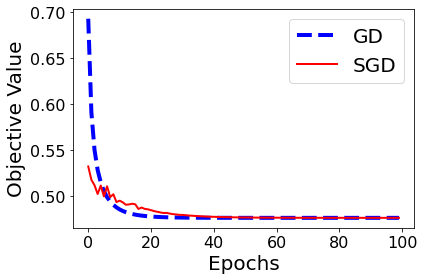

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4))

epochs_gd = range(len(objvals_gd))
epochs_sgd = range(len(objvals_sgd))

line0, = plt.plot(epochs_gd, objvals_gd, '--b', LineWidth=4)
line1, = plt.plot(epochs_sgd, objvals_sgd, '-r', LineWidth=2)
plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)
plt.legend([line0, line1], ['GD', 'SGD'], fontsize=20)
plt.tight_layout()
plt.show()
fig.savefig('compare_gd_sgd.pdf', format='pdf', dpi=1200)

# 5. Prediction

In [57]:
# Predict class label
# Inputs:
#     w: d-by-1 matrix
#     X: m-by-d matrix
# Return:
#     f: m-by-1 matrix, the predictions
def predict(w, X):
    xw = numpy.dot(X, w)
    f = numpy.sign(xw)
    return f

In [58]:
# evaluate training error
f_train = predict(w, x_train)
diff = numpy.abs(f_train - y_train) / 2
error_train = numpy.mean(diff)
print('Training classification error is ' + str(error_train))

Training classification error is 0.225


In [59]:
# evaluate test error
f_test = predict(w, x_test)
diff = numpy.abs(f_test - y_test) / 2
error_test = numpy.mean(diff)
print('Test classification error is ' + str(error_test))

Test classification error is 0.1953125


# 6. Mini-batch SGD (fill the code)



## 6.1. Compute the objective $Q_I$ and its gradient using a batch of samples

Define $Q_I (w) = \frac{1}{b} \sum_{i \in I} \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $, where $I$ is a set containing $b$ indices randomly drawn from $\{ 1, \cdots , n \}$ without replacement.

The stochastic gradient at $w$ is $g_I = \frac{\partial Q_I }{ \partial w} = \frac{1}{b} \sum_{i \in I} \frac{- y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

In [60]:
# Calculate the objective Q_I and the gradient of Q_I
# Inputs:
#     w: d-by-1 matrix
#     xi: b-by-d matrix
#     yi: b-by-1 matrix
#     lam: scalar, the regularization parameter
#     b: integer, the batch size
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
def mb_stochastic_objective_gradient(w, xi, yi, lam, b):
    #d = xi.shape[0]
    yx = numpy.multiply(yi,xi) #bxd
    yxw = numpy.dot(yx,w)  #bx1
    
    # calculate objective function Q_i
    loss = numpy.log(1 + numpy.exp(-yxw)) #bx1

    reg = lam / 2 * numpy.sum(w * w) #scalar
    obj = (1/b)*numpy.sum(loss) + reg
                   
    # calculate stochastic gradient
    z= (1/(1 + numpy.exp(yxw)))   #bx1
    #g_loss = -yx.T / (1 + numpy.exp(yxw)) # d-by-1 matrix
    g_loss = numpy.multiply(z,-yx).T #bxd
    g= (1/b)*numpy.sum(g_loss,axis=1)  #dx1
    g = g+ (lam*w)  #dx1
    
    return obj, g            
    

## 6.2. Implement mini-batch SGD

Hints:
1. In every epoch, randomly permute the $n$ samples (just like SGD).
2. Each epoch has $\frac{n}{b}$ iterations. In every iteration, use $b$ samples, and compute the gradient and objective using the ``mb_stochastic_objective_gradient`` function. In the next iteration, use the next $b$ samples, and so on.


In [63]:
# Mini-Batch SGD for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     b: integer, the batch size
#     stepsize: scalar
#     max_epoch: integer, the maximal epochs
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: the solution
#     objvals: record of each iteration's objective value

def mb_sgd(x, y, lam, b, stepsize, max_epoch=100, w=None):
    n, d = x.shape  #x= nxd
    objvals = numpy.zeros(max_epoch) # store the objective values   #1x100
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    
    for t in range(max_epoch):
        # randomly shuffle the samples
        rand_indices = numpy.random.permutation(n)
        x_rand = x[rand_indices, :]
        y_rand = y[rand_indices, :]
        
        objval = 0 # accumulate the objective values
        for i in range(int(n/b)):  #TODO: 
            xi = x_rand[(i*b):((i+1)*b), :] #bxd
            yi = y_rand[(i*b):((i+1)*b), :] #bx1
            obj, g = mb_stochastic_objective_gradient(w, xi, yi, lam, b )
            objval =objval+ obj
            w -= stepsize * g
        
        stepsize *= 0.9 # decrease step size #learning_rate
        objval /= int(n/b) 
        objvals[t] = objval
        print('Objective value at epoch t=' + str(t) + ' is ' + str(objval))
    
    return w, objvals


## 6.3. Run MB-SGD

In [64]:
lam = 1E-6 # do not change
b = 1 # do not change
stepsize = 0.1 # you must tune this parameter

xi= x_train[0:b,:]
yi= x_train[0:b,:]
w=numpy.zeros((d,1))
print(w, xi, yi)
obj, g = mb_stochastic_objective_gradient(w, xi, yi, lam, b )
print(obj, g)

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]] [[-0.85039959  0.60273526  0.2658729   0.36352226  0.8692748  -1.01070367
   1.18455681 -0.87772662  1.        ]] [[-0.85039959  0.60273526  0.2658729   0.36352226  0.8692748  -1.01070367
   1.18455681 -0.87772662  1.        ]]
0.6931471805599453 [[-0.36158973]
 [-0.1816449 ]
 [-0.0353442 ]
 [-0.06607422]
 [-0.37781934]
 [-0.51076095]
 [-0.70158742]
 [-0.38520201]
 [-0.5       ]]


In [65]:
# MB-SGD with batch size b=8
lam = 1E-6 # do not change
b = 8 # do not change
stepsize = 0.2 # you must tune this parameter

w, objvals_mbsgd8 = mb_sgd(x_train, y_train, lam, b, stepsize)

Objective value at epoch t=0 is 0.5284679165807347
Objective value at epoch t=1 is 0.49110042849816143
Objective value at epoch t=2 is 0.4834126964394492
Objective value at epoch t=3 is 0.4894313956434912
Objective value at epoch t=4 is 0.48574806494332023
Objective value at epoch t=5 is 0.48597994699358915
Objective value at epoch t=6 is 0.48594849139705926
Objective value at epoch t=7 is 0.48405040876479344
Objective value at epoch t=8 is 0.4819795473798438
Objective value at epoch t=9 is 0.48210636593600115
Objective value at epoch t=10 is 0.4819558736665037
Objective value at epoch t=11 is 0.4820416953611078
Objective value at epoch t=12 is 0.48169062118883754
Objective value at epoch t=13 is 0.48111501679320157
Objective value at epoch t=14 is 0.4803348822918442
Objective value at epoch t=15 is 0.4797633950681478
Objective value at epoch t=16 is 0.4796993589894581
Objective value at epoch t=17 is 0.4794929736279056
Objective value at epoch t=18 is 0.4794817765806491
Objective valu

In [66]:
# MB-SGD with batch size b=64
lam = 1E-6 # do not change
b = 64 # do not change
stepsize = 0.6 # you must tune this parameter

w, objvals_mbsgd64 = mb_sgd(x_train, y_train, lam, b, stepsize)

Objective value at epoch t=0 is 0.5650045779910257
Objective value at epoch t=1 is 0.49702976521420794
Objective value at epoch t=2 is 0.484456176353227
Objective value at epoch t=3 is 0.4818887240705297
Objective value at epoch t=4 is 0.4815044874083583
Objective value at epoch t=5 is 0.4806863848607283
Objective value at epoch t=6 is 0.48046703606839003
Objective value at epoch t=7 is 0.479873814235504
Objective value at epoch t=8 is 0.4793421094496253
Objective value at epoch t=9 is 0.4793304601704042
Objective value at epoch t=10 is 0.47888612336998726
Objective value at epoch t=11 is 0.4783191977967867
Objective value at epoch t=12 is 0.47881713035615137
Objective value at epoch t=13 is 0.4783904452011045
Objective value at epoch t=14 is 0.47800691806300044
Objective value at epoch t=15 is 0.4783267370261853
Objective value at epoch t=16 is 0.4776260340983957
Objective value at epoch t=17 is 0.4780388610307952
Objective value at epoch t=18 is 0.477673854027998
Objective value at e

# 7. Plot and compare GD, SGD, and MB-SGD

You are required to compare the following algorithms:

- Gradient descent (GD)

- SGD

- MB-SGD with b=8

- MB-SGD with b=64

Follow the code in Section 4 to plot ```objective function value``` against ```epochs```. There should be four curves in the plot; each curve corresponds to one algorithm.

Hint: Logistic regression with $\ell_2$-norm regularization is a strongly convex optimization problem. All the algorithms will converge to the same solution. **In the end, the ``objective function value`` of the 4 algorithms will be the same. If not the same, your implementation must be wrong. Do NOT submit wrong code and wrong result!**

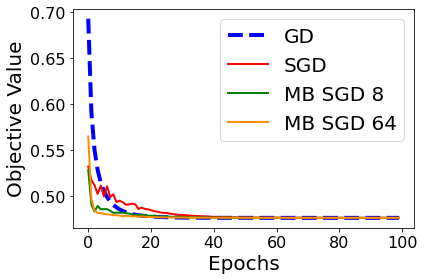

In [71]:
# plot the 4 curves:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4))

gdEpochs=range(len(objvals_gd))
sgdEpochs=range(len(objvals_sgd))
mbsgd8Epochs=range(len(objvals_mbsgd8))
mbsgd64Epochs=range(len(objvals_mbsgd64))

line0, = plt.plot(gdEpochs, objvals_gd, '--b', LineWidth=4)
line1, = plt.plot(sgdEpochs, objvals_sgd, '-r', LineWidth=2)
line2, = plt.plot(mbsgd8Epochs, objvals_mbsgd8, '-g', LineWidth=2)
line3, = plt.plot(mbsgd64Epochs, objvals_mbsgd64,color='darkorange', LineWidth=2)

plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)

plt.legend([line0, line1, line2,line3], ['GD', 'SGD' , 'MB SGD 8', 'MB SGD 64'], fontsize=20)
plt.tight_layout()
plt.show()
fig.savefig('compare_gd_sgd_mb_8_mb_64.pdf', format='pdf', dpi=1200)